In [1]:
from decoder import *
from encoder import *
from textEncoder import *
# from genZero import *
from genConditioning import *
from other_data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt


[nltk_data] Downloading package punkt to /home/srajguru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:


def validate(val_loader, encoder, decoder, embed, stack, maxSeqLen,
             vocab, lam, batch_size, use_gpu = True):

    
    #Evaluation Mode
    decoder.eval()
    encoder.eval()
    embed.eval()
    stack.eval()
    #lam = 20
    # critereon
    discCrit = nn.BCEWithLogitsLoss()
    textCrit = nn.CrossEntropyLoss()
    distCrit = nn.SmoothL1Loss()
    if use_gpu:
        device = torch.device("cuda:0")
        
    total = 0
    correct = 0
    tp = 0
    tn = 0
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0
        disc_loss_avg = 0
                
        for i, (inputs, labels, wrong_labels, lengths, wrong_lengths) in enumerate(val_loader):
            
            
            
            # Move to device, if available
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
                wrong_labels = wrong_labels.to(device)
                        

            #STEM
#             embed.resetHidden(labels.shape[0])
#             pred_out, w, s = embed(labels, lengths)
#             pred_out_wrong, w_wrong, s_wrong = embed(wrong_labels.cuda(), wrong_lengths)
            
#             #GLAM
#             generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
            
            
#             # STREAM
#             enc_out = encoder(generated_imgs)

#             decoder.resetHidden(inputs.shape[0])
#             outputs = decoder(labels, enc_out, lengths) #calls forward

            embed.resetHidden(labels.shape[0])
            pred_out, w, s = embed(labels, lengths)
            pred_out_wrong, w_wrong, s_wrong = embed(wrong_labels, wrong_lengths)
            
            #GLAM
#             print('inputs shape: ', inputs.size())
            generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
            generated_imgs_wrong, h0s_wrong, discr_gen_wrong, discr_real_wrong = stackZero(s_wrong, inputs)
#             print('discr_gen shape: ', discr_gen.size())
#             print('discr_real shape: ', discr_real.size())
            
            
            # STREAM
            enc_out = encoder(generated_imgs)

            decoder.resetHidden(inputs.shape[0])
            outputs = decoder(labels, enc_out, lengths) #calls forward
            
            
            loss = (
                    #distCrit(generated_imgs, inputs)
                    lam*textCrit(outputs, labels.cuda())
                    #discCrit(discr_real, torch.ones(discr_real.shape).cuda())
            )
            discloss = (
                    discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
                    + discCrit(discr_real, torch.ones(discr_real.shape).cuda()) + discCrit(discr_real_wrong, torch.zeros(discr_real_wrong.shape).cuda())
                )
            loss_avg += loss.item()
            disc_loss_avg += discloss.item()
            count+=1
            
            
            total += inputs.shape[0]*2
            
            bound = torch.ones(inputs.shape[0]).cuda()*0.5
            realOut = torch.where(discr_real.squeeze() > bound,
                                  torch.tensor([1]).cuda(), torch.tensor([0]).cuda())
            fakeOut = torch.where(discr_gen.squeeze() > bound,
                                  torch.tensor([0]).cuda(), torch.tensor([1]).cuda())
#             realOut = torch.where(nn.Sigmoid()(discr_real.squeeze()) > bound,
#                                   torch.tensor([1]).cuda(), torch.tensor([0]).cuda())
#             fakeOut = torch.where(nn.Sigmoid()(discr_gen.squeeze()) > bound,
#                                   torch.tensor([0]).cuda(), torch.tensor([1]).cuda())
            
            tp += torch.sum(realOut).item()
            tn += torch.sum(fakeOut).item()
            correct += (torch.sum(realOut) + torch.sum(fakeOut)).item()
            
            
            del labels
            del inputs
            del outputs            
            
            

                
        loss_avg  = loss_avg/count
        
        disc_loss_avg = disc_loss_avg / count
        print("Generator loss: {}".format(loss_avg))
        print("Discriminator loss: {}".format(disc_loss_avg))
        print("Discriminator Accuracy: {}".format(correct/total))
        print("\nTrue Positive: {}".format(tp))
        print("False Positive (Deceived!): {}".format((total/2) - tn))
        print("True Negative: {}".format(tn))
        print("False Negative: {}".format((total/2) - tp))


        
        
            
    return loss_avg, disc_loss_avg

In [3]:
def custom_disc_loss(sr, sw, sf):
    return torch.log(sr) + (torch.log(torch.ones(sw.shape).cuda() - sw) + torch.log(torch.ones(sf.shape).cuda() - sf))/2.0

In [4]:
def print_log(s):
    if os.path.exists('./baseline.log'):
        f = open('./baseline.log', 'a')
    else:
        f = open('./baseline.log', 'w')
    f.write(s+'\n')
    print(s)
    f.close()

In [5]:
def trainStack(encoder, decoder, embed, stackZero, epochs, train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab, lam, disc_gen_split, save_generated_imgs= False):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    
    try:
        os.mkdir('./generated_imgs')
    except:
        pass
    
    generated_imgs_filename = './generated_imgs/generated_imgs' + name + '_summary' + str(i) + '.log'
    
    parameters = list(stackZero.parameters())
    optimizer_G = optim.Adam(parameters, lr=2e-4)
    optimizer_D = optim.Adam(parameters, lr=2e-4/10.0)
    
    lamBuf = lam
    #discCrit = nn.BCEWithLogitsLoss()
    discCrit = nn.BCELoss()
    textCrit = nn.CrossEntropyLoss()
    distCrit = nn.SmoothL1Loss()
    
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")

        encoder.to(device)
        decoder.to(device)
        embed.to(device)
        stackZero.to(device)
    temperature=1
    
    val_loss_disc_set = []
    val_loss_gen_set = []

    training_loss_disc = []
    training_loss_gen = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 7
    earlyStopDelta = 3
    
    val_loss = validate(val_loader, encoder, decoder, embed, stackZero, maxSeqLen,
                             vocab, batch_size, use_gpu)
    for epoch in range(0, epochs):
        ts = time.time()
        
        if epoch % 5 == 0:
            lam = 0
        else:
            lam = lamBuf

        for iter, (inputs, labels, wrong_labels, lengths, wrong_lengths) in tqdm(enumerate(train_loader)):

            optimizer_G.zero_grad()
            
            stackZero.train()
            encoder.train()
            decoder.train()
            embed.train()
            
#             raw_caption = (" ").join(
#                 [vocab.idx2word[x.item()] for x in labels[0] if vocab.idx2word[x.item()] is not '<pad>'])
#             wrong_caption = (" ").join(
#                 [vocab.idx2word[x.item()] for x in wrong_labels[0] if vocab.idx2word[x.item()] is not '<pad>'])
#             print("Base Caption: " + raw_caption)
#             print("Wrong Caption: " + wrong_caption)
            
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
                wrong_labels = wrong_labels.to(device)
            
            
            #For first epoch will train the discriminator/generator everyother iteration
#             if epoch ==0:
#                 #print("0")
#                 if iter % (10*disc_gen_split) == 0:
#                     # Train discriminator
#                     for param in stackZero.parameters():
#                         param.requires_grad = False
                        
#                     stackZero.setDiscriminatorGrad(True)
                    
#                 else:
#                     # Train generator
#                     for param in stackZero.parameters():
#                         param.requires_grad = True
#                     stackZero.setDiscriminatorGrad(False)
#                     discParameters = list(stackZero.D0_down.parameters())
#                     discParameters.extend(stackZero.D0_join.parameters())
#                     discParameters.extend(stackZero.D0_judge.parameters())
#                     for param in discParameters:
#                         param.requires_grad = False
            
            # Set generator to train
            for param in stackZero.parameters():
                param.requires_grad = True
            stackZero.setDiscriminatorGrad(False)
                    
            # After first epoch will train discriminator every 5 epochs
#             elif epoch % disc_gen_split == 0:
                
#                 # Train discriminator
#                 for param in stackZero.parameters():
#                     param.requires_grad = False
                        
#                 stackZero.setDiscriminatorGrad(True)
                
#             else:
                
#                 # Train generator
#                 for param in stackZero.parameters():
#                     param.requires_grad = True
                        
#                 stackZero.setDiscriminatorGrad(False)
                
            
            
            
            # Generator stuff
            
            #STEM
            embed.resetHidden(labels.shape[0])
            pred_out, w, s = embed(labels, lengths)
            pred_out_wrong, w_wrong, s_wrong = embed(wrong_labels, wrong_lengths)
            
            #GLAM
#             print('inputs shape: ', inputs.size())
            generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
            generated_imgs_wrong, h0s_wrong, discr_gen_wrong, discr_real_wrong = stackZero(s_wrong, inputs)
#             print('discr_gen shape: ', discr_gen.size())
#             print('discr_real shape: ', discr_real.size())
            
            
            # STREAM
            enc_out = encoder(generated_imgs)

            decoder.resetHidden(inputs.shape[0])
            outputs = decoder(labels, enc_out, lengths) #calls forward
            
            # Generator loss
            gen_loss_new = (
                lam*textCrit(outputs, labels) + discCrit(discr_gen, torch.ones(discr_real.shape).cuda())
            )
            
            gen_loss_new.backward(retain_graph=True)
            optimizer_G.step()
            
            # Now Discriminator
            if iter % 10 == 0:
                optimizer_D.zero_grad()

                # Set Discriminator to train
                for param in stackZero.parameters():
                    param.requires_grad = False
                stackZero.setDiscriminatorGrad(True)

                # Discriminator stuff
    #             embed.resetHidden(labels.shape[0])
    #             pred_out, w, s = embed(labels, lengths)
    #             pred_out_wrong, w_wrong, s_wrong = embed(wrong_labels, wrong_lengths)

                #GLAM
    #             print('inputs shape: ', inputs.size())
                generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
                generated_imgs_wrong, h0s_wrong, discr_gen_wrong, discr_real_wrong = stackZero(s_wrong, inputs)
    #             print('discr_gen shape: ', discr_gen.size())
    #             print('discr_real shape: ', discr_real.size())


                # STREAM
                enc_out = encoder(generated_imgs)

                decoder.resetHidden(inputs.shape[0])
                outputs = decoder(labels, enc_out, lengths) #calls forward

    #             loss = custom_disc_loss(discr_real, discr_real_wrong, discr_gen)
                disc_loss_new = (
                    discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda()) + discCrit(discr_real, torch.ones(discr_real.shape).cuda()) + discCrit(discr_real_wrong, torch.zeros(discr_real_wrong.shape).cuda())
                )

    #             print(type(loss))
    #             print(loss)
                disc_loss_new.backward()
                optimizer_D.step()

            #For first epoch will train the discriminator/generator everyother iteration
#             if epoch ==0:
#                 #print("0")
#                 if iter % (10*disc_gen_split) == 0:
#                     # Train discriminator
# #                     loss = (
# #                         discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda()) 
# #                         + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
# #                     )
#                     loss = (
#                         custom_disc_loss(discr_real, discr_real_wrong, discr_gen)
#                     )
#                 else:
#                     # Train generator
#                     loss = (
#                         #distCrit(generated_imgs, inputs)
#                         lam*textCrit(outputs, labels.cuda())
#                         + discCrit(discr_gen, torch.ones(discr_real.shape).cuda())
#                         #- discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
#                     )
                    
                    
#             # After first epoch will train discriminator every 5 epochs
#             elif epoch % disc_gen_split == 0:
                
#                 # Train discriminator
# #                 loss = (
# #                         discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda()) 
# #                         + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
# #                 )
#                 loss = (
#                     custom_disc_loss(discr_real, discr_real_wrong, discr_gen)
#                 )
#             else:
                
#                 # Train generator
#                 loss = (
#                     #distCrit(generated_imgs, inputs)
#                     lam*textCrit(outputs, labels)
#                     + discCrit(discr_gen, torch.ones(discr_real.shape).cuda())
#                     #- discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
#                 )
            
#             del labels
#             del outputs

#             loss.backward()
#             loss = loss#.item()
#             optimizer.step()

            if iter % 200 == 0:
                print_log("epoch{}, iter{}, disc_loss: {}, gen_loss: {}".format(epoch, iter, disc_loss_new.item(), gen_loss_new.item()))

                
        print_log("epoch{}, iter{}, disc_loss: {}, gen_loss: {}, epoch duration: {}".format(epoch, iter, disc_loss_new.item(), gen_loss_new.item(), time.time() - ts))
        test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()
        
        k = 0
        for b in range(inputs.shape[0]):
            gen_caption = (" ").join(
                [vocab.idx2word[x.item()] for x in test_pred[b] if vocab.idx2word[x.item()] is not '<pad>'])
            raw_caption = (" ").join(
                [vocab.idx2word[x.item()] for x in labels[b] if vocab.idx2word[x.item()] is not '<pad>'])
            wrong_caption = (" ").join(
                [vocab.idx2word[x.item()] for x in wrong_labels[b] if vocab.idx2word[x.item()] is not '<pad>'])
            gen_img = tf.ToPILImage()(generated_imgs[b,:,:,:].cpu())
            raw_img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
                    
            plt.figure(figsize=(14,8))
            plt.subplot(1,2,1)
            plt.imshow(raw_img)
            plt.subplot(1,2,2)
            plt.imshow(gen_img)      
            plt.show()
            print("Base Caption: " + raw_caption)
            print("Generated Caption: " + gen_caption)
            print("Wrong Caption: " + wrong_caption)
            
            if save_generated_imgs:
                file = "./generated_imgs/" + "train_epoch" + str(epoch) + "im_"+ str(k) 
                img.save(file + ".png", "PNG")
                k+=1
                with open(generated_imgs_filename, "a") as file:
                    file.write("writing! " + "train_epoch" + str(epoch) + "im_"+ str(k) + "\n")            
                    file.write("Caption: " + caption +"\n \n")
        del labels
        del wrong_labels
        del outputs
        # calculate val loss each epoch
        val_loss_gen, val_loss_disc = validate(val_loader, encoder, decoder, embed, stackZero, maxSeqLen,
                             vocab, batch_size, use_gpu)
        val_loss_disc_set.append(val_loss_disc)
        val_loss_gen_set.append(val_loss_gen)

        print("epoch{}, iter{}, disc val loss: {}, gen val loss: {}, epoch duration: {}".format(epoch, iter, val_loss_disc, val_loss_gen, time.time() - ts))
        
        training_loss_disc.append(disc_loss_new)
        training_loss_gen.append(gen_loss_new)
        
        torch.save(stackZero, 'weights/stack0_{}_epoch{}'.format(name, epoch))

        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss Disc:   " + str(disc_loss_new.item()))
            file.write("\n training Loss Gen:   " + str(gen_loss_new.item()))
            file.write("\n Validation Loss Disc: " + str(val_loss_disc_set[-1]))
            file.write("\n Validation Loss Gen: " + str(val_loss_gen_set[-1]))
                                          
                                                                                                
                                                                                                
        
        # Early stopping
#         if val_loss < minLoss:
#             # Store new best
#             torch.save(stackZero, 'weights/stack0_{}_best'.format(name))
#             minLoss = val_loss#.item()
#             minLossIdx = epoch
            
#         #If passed min threshold, and no new min has been reached for delta epochs
#         elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
#             print("Stopping early at {}".format(minLossIdx))
#             break
        

        
        
        with open(logname_summary, "w") as file:
            file.write("Summary!\n")
            #file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss Disc:   " + str(training_loss_disc))   
            file.write("\n training Loss gen:   " + str(training_loss_gen))   
            file.write("\n Validation Loss Disc: " + str(val_loss_disc_set))
            file.write("\n Validation Loss Gen: " + str(val_loss_gen_set))



found 7323 train ids
found 866 test ids
# ids: 58590
# ids: 14640
# ids: 8660
Loading results to logfile: ./logs/genOnly26.log
Loading Summary to : ./logs/genOnly_summary26.log
Generator loss: 9.111990251827761
Discriminator loss: 2.4018028883334717
Discriminator Accuracy: 0.5

True Positive: 0
False Positive (Deceived!): 0.0
True Negative: 14640
False Negative: 14640.0


2it [00:01,  1.16s/it]

epoch0, iter0, disc_loss: 2.1071221828460693, gen_loss: 0.7118851542472839


202it [00:32,  6.22it/s]

epoch0, iter200, disc_loss: 1.9256731271743774, gen_loss: 1.033508539199829


402it [01:03,  5.83it/s]

epoch0, iter400, disc_loss: 1.7677280902862549, gen_loss: 1.304430365562439


602it [01:33,  6.41it/s]

epoch0, iter600, disc_loss: 1.828369140625, gen_loss: 1.254221796989441


802it [02:05,  6.27it/s]

epoch0, iter800, disc_loss: 1.95084810256958, gen_loss: 1.028160810470581


1002it [02:36,  6.12it/s]

epoch0, iter1000, disc_loss: 1.8450181484222412, gen_loss: 1.5040868520736694


1202it [03:04,  6.12it/s]

epoch0, iter1200, disc_loss: 1.9153926372528076, gen_loss: 1.1671807765960693


1402it [03:34,  6.19it/s]

epoch0, iter1400, disc_loss: 1.9329748153686523, gen_loss: 1.0962011814117432


1602it [04:06,  5.89it/s]

epoch0, iter1600, disc_loss: 1.7088253498077393, gen_loss: 1.5687099695205688


1802it [04:37,  6.28it/s]

epoch0, iter1800, disc_loss: 1.9478864669799805, gen_loss: 1.3067195415496826


2002it [05:08,  6.61it/s]

epoch0, iter2000, disc_loss: 1.7050797939300537, gen_loss: 1.5053045749664307


2202it [05:39,  5.88it/s]

epoch0, iter2200, disc_loss: 1.7509101629257202, gen_loss: 1.8335521221160889


2402it [06:09,  6.25it/s]

epoch0, iter2400, disc_loss: 1.7873561382293701, gen_loss: 1.5271610021591187


2602it [06:40,  6.23it/s]

epoch0, iter2600, disc_loss: 1.6713950634002686, gen_loss: 1.6230942010879517


2802it [07:12,  6.35it/s]

epoch0, iter2800, disc_loss: 1.8425507545471191, gen_loss: 1.2683088779449463


2930it [07:32,  6.94it/s]


epoch0, iter2929, disc_loss: 1.8360087871551514, gen_loss: 1.41670823097229, epoch duration: 453.9030227661133


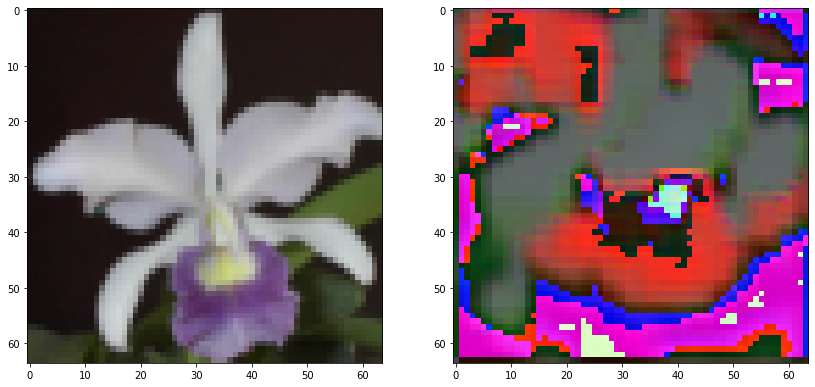

Base Caption: <start> this is a white flower with one purple petal that has a yellow center . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower has pure white petals that form a pentagon shaped come around a yellow stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


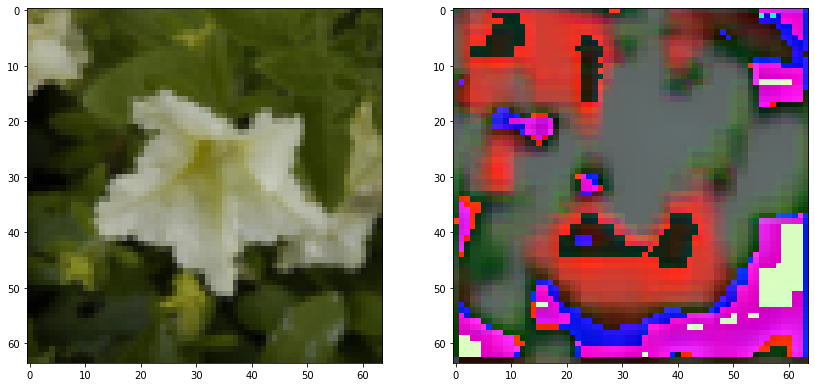

Base Caption: <start> the flower has white petals with a green pedicel and green sepel . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower has a number of light pink petals with slightly darker veins and rounded edges . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


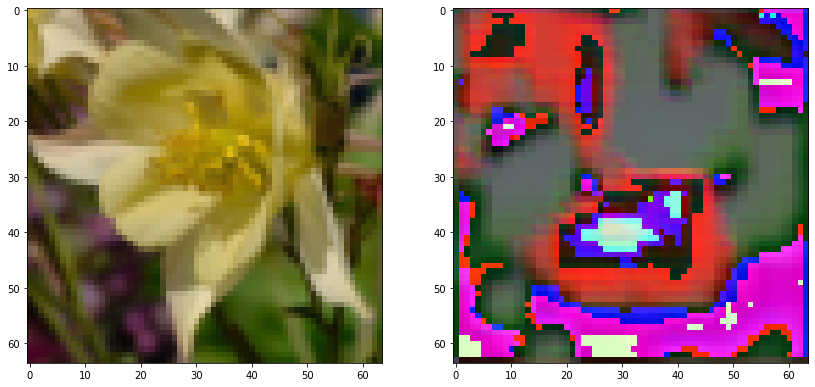

Base Caption: <start> the flower shown has yellow anther and filament to go with yellow petals <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> the flower has petals that are red with white edges and red filaments . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


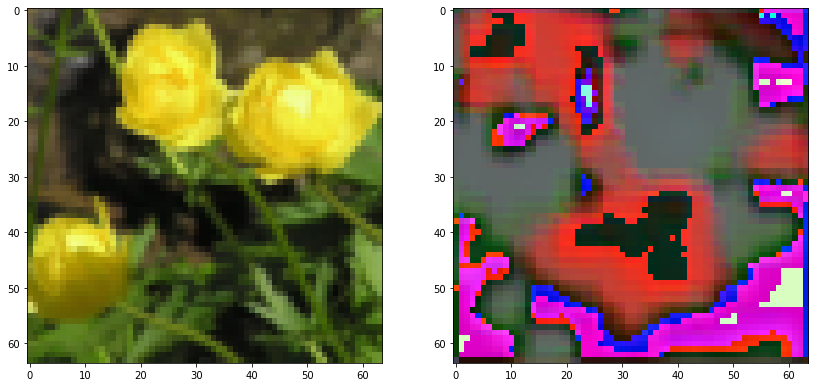

Base Caption: <start> the flower has petals that are overlapping and yellow with green pedicel . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower is purple in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


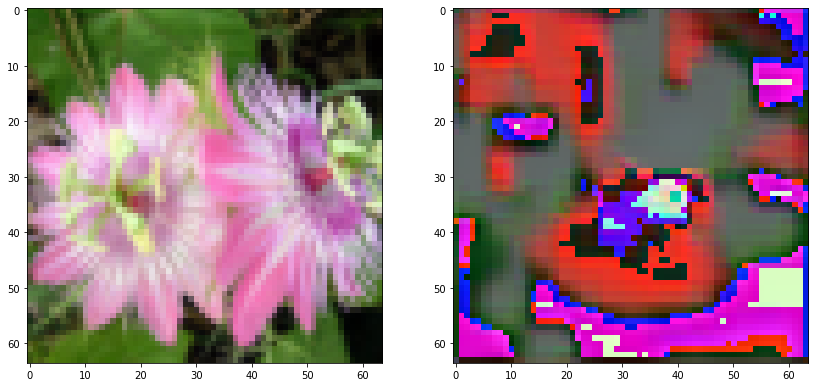

Base Caption: <start> this flower has large green-yellow stamens and two types of purple petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower has petals that are pink with many <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


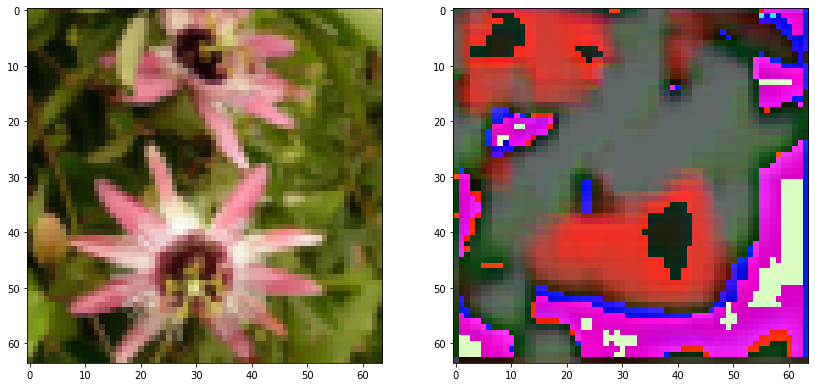

Base Caption: <start> the flower is big and has disc of petals that are soft <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> a long green pedicel is present as well as a drooping purple petal with white spots . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


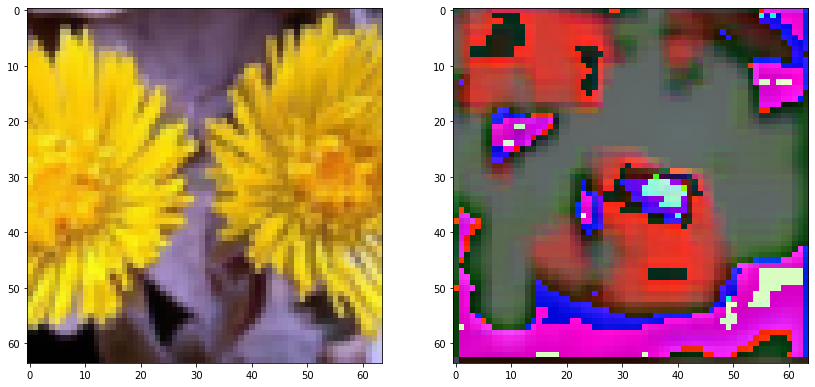

Base Caption: <start> flower has many needle shaped petals that are yellow incolor <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and very stringy <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower has orange petals with small white stamen in the middle <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


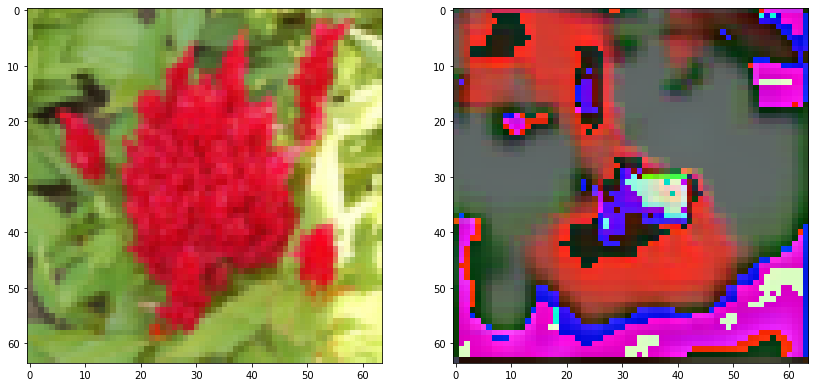

Base Caption: <start> this flower has petals that are red with ruffled texture <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower is yellow in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


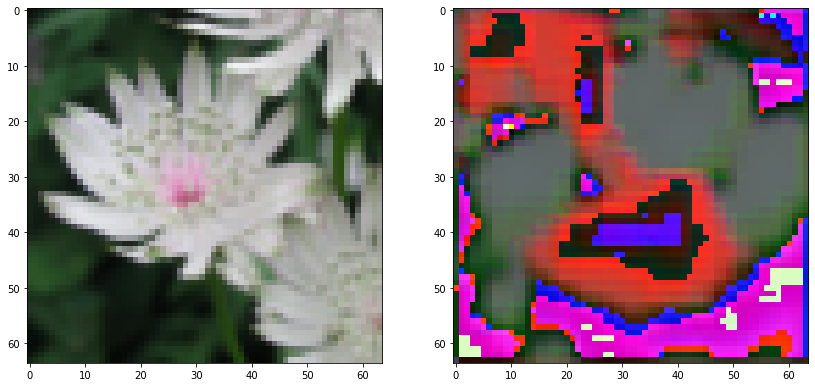

Base Caption: <start> this flower is yellow and pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has a purple center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> the flower petals are light purple in color with yellow anthes <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


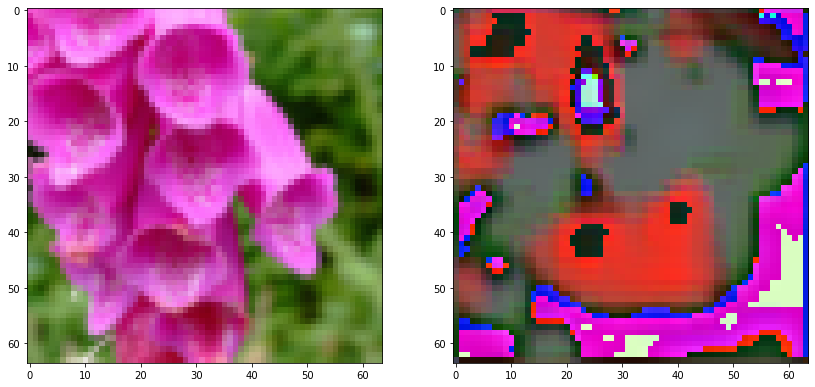

Base Caption: <start> this flower is pink and white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> peach colored pedals that are opened up on the outside wrapping tighter the closer you get to the stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generator loss: 8.7139892578125
Discriminator loss: 2.28224153759701
Discriminator Acc

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BaseGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Upsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/pyth

epoch1, iter0, disc_loss: 1.8845503330230713, gen_loss: 1.3716473579406738


202it [00:33,  5.68it/s]

epoch1, iter200, disc_loss: 1.79759681224823, gen_loss: 1.4711894989013672


402it [01:05,  5.47it/s]

epoch1, iter400, disc_loss: 1.6748840808868408, gen_loss: 1.6957931518554688


602it [01:38,  5.87it/s]

epoch1, iter600, disc_loss: 1.7475471496582031, gen_loss: 1.667279839515686


802it [02:09,  6.16it/s]

epoch1, iter800, disc_loss: 1.7740283012390137, gen_loss: 1.5849345922470093


1002it [02:41,  6.09it/s]

epoch1, iter1000, disc_loss: 1.630135178565979, gen_loss: 1.7976338863372803


1202it [03:10,  6.23it/s]

epoch1, iter1200, disc_loss: 1.5327062606811523, gen_loss: 2.336895704269409


1402it [03:42,  5.71it/s]

epoch1, iter1400, disc_loss: 1.7156332731246948, gen_loss: 1.4622873067855835


1602it [04:13,  5.78it/s]

epoch1, iter1600, disc_loss: 1.788115382194519, gen_loss: 1.3863013982772827


1802it [04:45,  6.06it/s]

epoch1, iter1800, disc_loss: 1.6438391208648682, gen_loss: 2.0581226348876953


2002it [05:16,  6.10it/s]

epoch1, iter2000, disc_loss: 1.5469365119934082, gen_loss: 2.232072591781616


2202it [05:47,  5.85it/s]

epoch1, iter2200, disc_loss: 1.634093999862671, gen_loss: 1.794866919517517


2402it [06:19,  6.42it/s]

epoch1, iter2400, disc_loss: 1.61431884765625, gen_loss: 1.9502252340316772


2602it [06:50,  6.02it/s]

epoch1, iter2600, disc_loss: 1.7325711250305176, gen_loss: 1.7367912530899048


2802it [07:20,  5.81it/s]

epoch1, iter2800, disc_loss: 1.6409684419631958, gen_loss: 1.9286712408065796


2930it [07:40,  7.23it/s]


epoch1, iter2929, disc_loss: 1.6672985553741455, gen_loss: 1.7805458307266235, epoch duration: 462.2305974960327


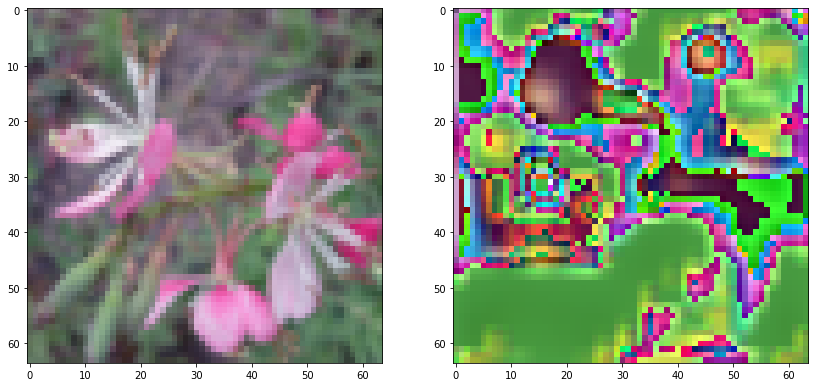

Base Caption: <start> this flower has long protruding stamen that are white and brown tips and also has purple petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower is <unk> a sphere of many straight <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


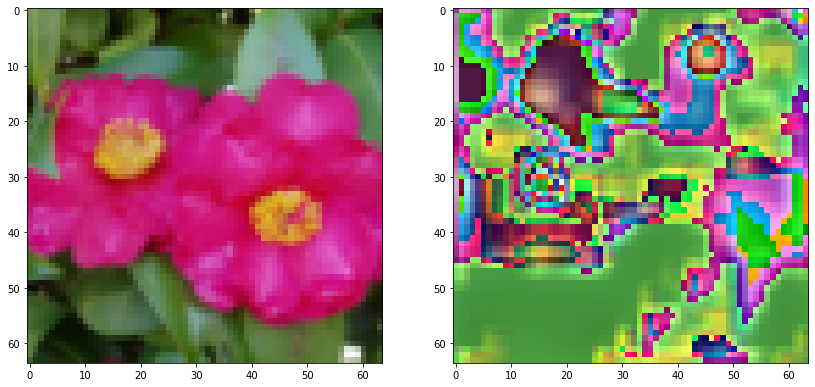

Base Caption: <start> this flower has a dense amount of large dark pink leaves with bright yellow stamens . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> the petals are bright gold and arranged on long stalks and the sepals are green and pointed . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


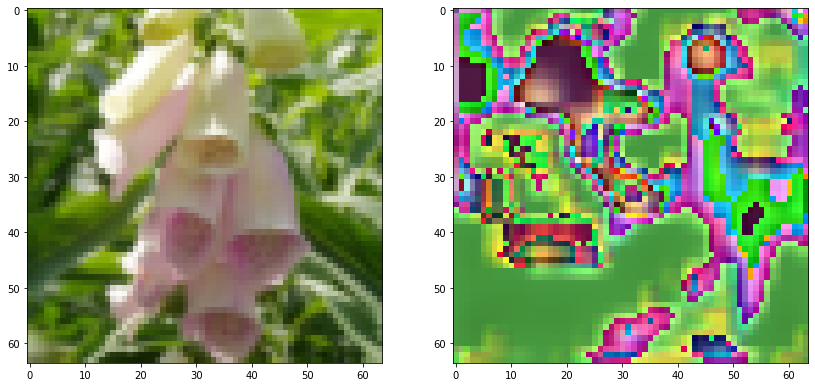

Base Caption: <start> a flower with a bell shaped petal that has speckles on it 's surface . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower is pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


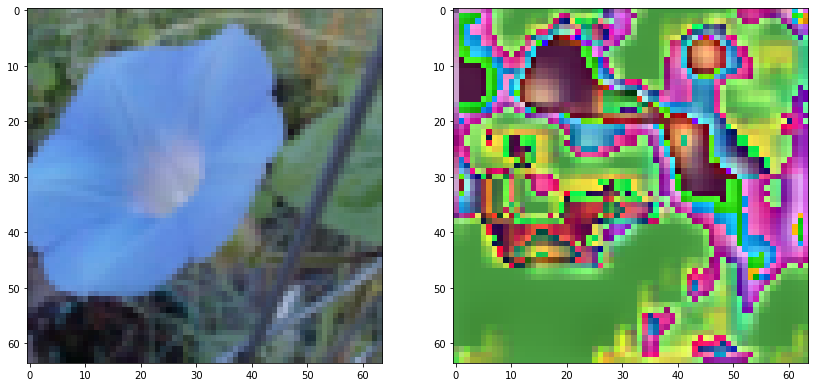

Base Caption: <start> this flower is trumpet shaped and has blue petals with a whitish middle . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower has purple petals that <unk> out from the sepal <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


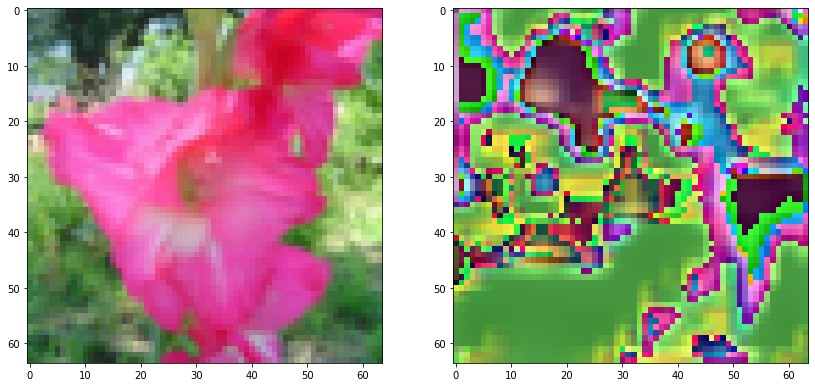

Base Caption: <start> this flower has pink petals as well as a pink stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are orange and has yellow shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> several yellow petals surround a region of red spots in the center with some hairy yellow stamen in the center . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


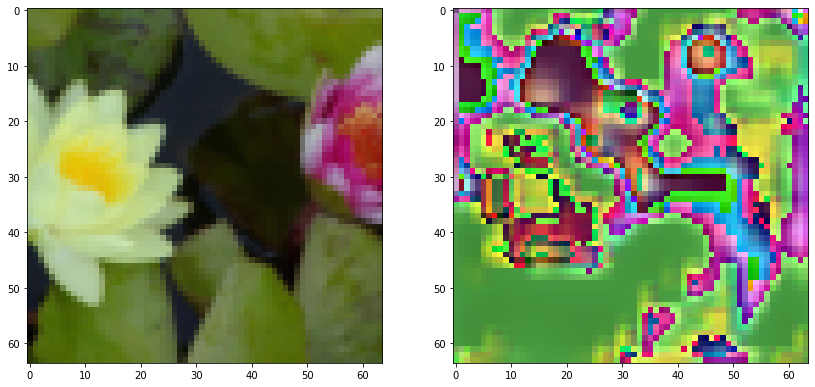

Base Caption: <start> this flower has petals that are whiet and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has red dots <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this flower has pink petals that are thin and curled at the ends <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


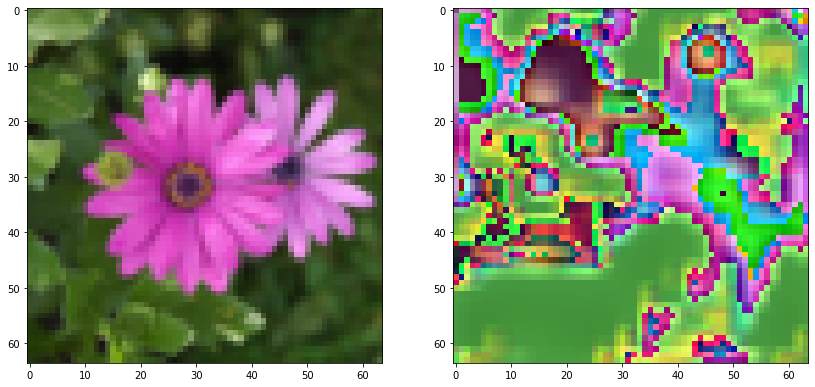

Base Caption: <start> this flower has thin purple petals with small yellow stamens . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> these flowers possess yellow and white petals and a lighter <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


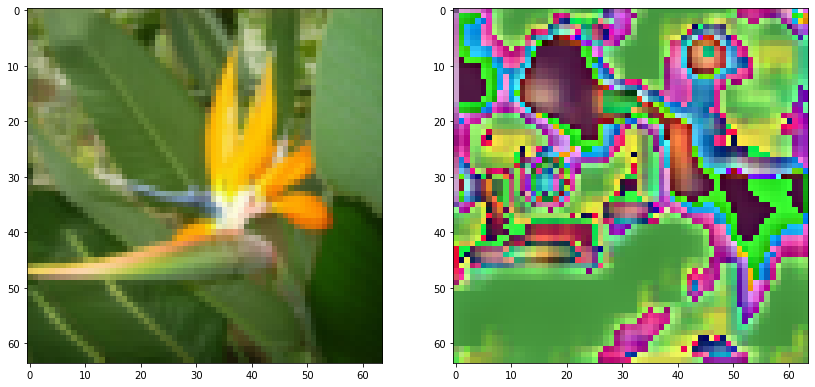

Base Caption: <start> this flower has petals that are orange and very <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> the flower has purple and green petals with thin purple petals in the middle . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


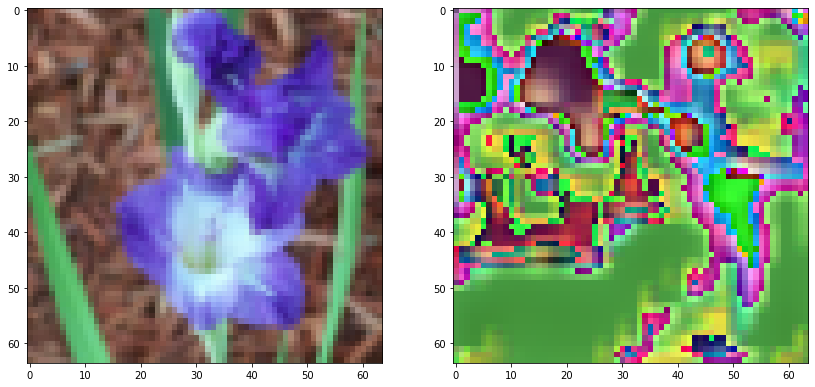

Base Caption: <start> the petals are broad but thin at the edges <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> the petals of the flower are yellow in color and have leaves that are green . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


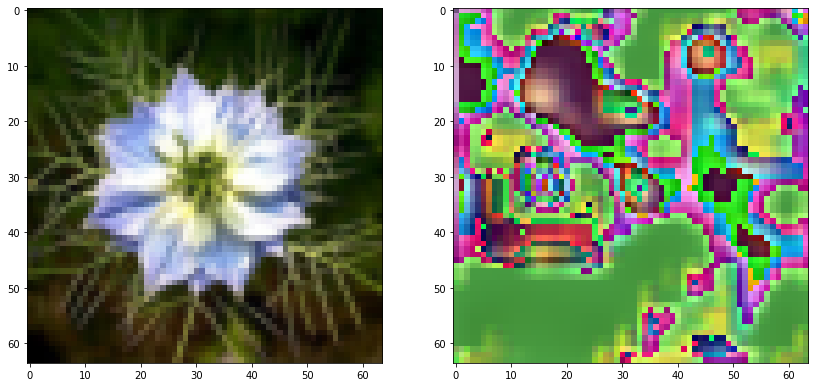

Base Caption: <start> there are many overlapping pale violet petals <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Wrong Caption: <start> this bright pink flower has two lavender petals coming from each side from the middle . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generator loss: 8.72076878912462
Discriminator loss: 2.27617448

2it [00:01,  1.30s/it]

epoch2, iter0, disc_loss: 1.6627812385559082, gen_loss: 1.731184720993042


202it [00:33,  6.12it/s]

epoch2, iter200, disc_loss: 1.6352871656417847, gen_loss: 2.4214298725128174


402it [01:05,  6.30it/s]

epoch2, iter400, disc_loss: 1.5047820806503296, gen_loss: 2.878117561340332


602it [01:36,  5.93it/s]

epoch2, iter600, disc_loss: 1.4712448120117188, gen_loss: 3.147052049636841


802it [02:07,  6.30it/s]

epoch2, iter800, disc_loss: 1.4635597467422485, gen_loss: 2.86751127243042


1002it [02:38,  6.02it/s]

epoch2, iter1000, disc_loss: 1.480663776397705, gen_loss: 3.339076280593872


1202it [03:10,  5.96it/s]

epoch2, iter1200, disc_loss: 1.4212465286254883, gen_loss: 3.299211025238037


1402it [03:40,  6.07it/s]

epoch2, iter1400, disc_loss: 1.4820337295532227, gen_loss: 3.2278270721435547


1572it [04:07,  6.33it/s]

KeyboardInterrupt: 

In [6]:
if __name__=='__main__':
    with open('trainvalIds.csv', 'r') as f:
        trainIds = []
        for line in f:
            if len(line) > 1:
                trainIds.append(line.strip("\n"))

        
    with open('testIds.csv', 'r') as f:
        testIds = []
        for line in f:
            if len(line) > 1:
                testIds.append(line.strip("\n"))
    
    print("found {} train ids".format(len(trainIds)))
    print("found {} test ids".format(len(testIds)))
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/realImages/"
    testRoot = "./data/realImages/"
    
    trainValCaps = "./data/captions/trainvalCaps.csv"
    testCaps = "./data/captions/testCaps.csv"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 64
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 20
    shuffle = True
    num_workers = 20
    
    
    trainDl = get_loader(trainValRoot, trainValCaps, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    valDl = get_loader(trainValRoot, trainValCaps, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    testDl = get_loader(testRoot, testCaps, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=num_workers)
    
    encoded_feature_dim = 800
    maxSeqLen = 49
    hidden_dim = 1500
    depth = 1
    
    embed = torch.load('./weights_old/bs{}_embed_best'.format(batch_size))
    
    encoder = torch.load('./weights_old/lstm{}encoder_best'.format(img_side_length))
    decoder = torch.load('./weights_old/lstm{}decoder_best'.format(img_side_length))
    # Turn off all gradients in encoder
    for param in embed.parameters():
        param.requires_grad = False
        
    for param in encoder.parameters():
        param.requires_grad = False

    for param in decoder.parameters():
        param.requires_grad = False

    
#     criterion = nn.NLLLoss()
    stackZero = BaseGenerator(batch_size, embed.hidden_dim)
#     stackZero = torch.load('./weights/stack0_genOnly_epoch1')
    epochs = 100
    disc_gen_split = 4
    lam = 0
    trainStack(encoder, decoder, embed, stackZero, epochs, trainDl, valDl, testDl, "genOnly",
                batch_size, maxSeqLen, vocab, lam, disc_gen_split,save_generated_imgs = False)

In [ ]:
%debug

In [ ]:
with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
vocab.idx

In [ ]:
import torch
import torch.optim as optim
import os
#print(os.getcwd())
embed = torch.load('./weights/base_embed_best')
embed.batch_size
optimizer = optim.Adam(list(embed.parameters()), lr=5e-5)

help(optimizer.step)
